This notebook provides an approach to visualize the wearable wear behavior of a single
participant. 

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

from code_utils.path_conf import mbrain_metadata_path, processed_mbrain_path
from code_utils.utils.interaction_analysis import get_wearable_session_df
from code_utils.mbrain.event_parsing import EventDumpParser
from datetime import datetime

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [2]:
# ---------------------------- Hyperparameters ---------------------------- #
USE_PNG = True # whether the figure is displayed via a static image or interactive plot
user = "MBRAIN21-002"
W_SIZE_MIN_DAY = 30  # the aggregation window size in minutes for time of day analysis
W_SIZE_MIN_WEEK = 60  # the aggregation window size in minutes for day of week analysis
# ------------------------------------------------------------------------ #

In [3]:
# fmt: off
# utilize the wearable temperature data to construct the session dataframe
df_tmp = pd.concat([pd.read_parquet(f).set_index('timestamp') for f in processed_mbrain_path.glob(f'{user}*E4*/tmp*.parquet')]).sort_index()
df_wrist_wearable_sessions = get_wearable_session_df(processed_mbrain_path.glob(f'{user}*E4*/tmp*.parquet'), fs_exp=1)
dt = df_tmp.index[0].replace(hour=0, minute=0, second=0, microsecond=0)

# derive the daily data ratio
df_res_dr = df_tmp.resample(f'{W_SIZE_MIN_DAY}min').count() / (60 * 4 * W_SIZE_MIN_DAY)
df_time_day_mean = df_res_dr.groupby([df_res_dr.index.hour, df_res_dr.index.minute]).mean()
df_time_day_mean.index = df_time_day_mean.index.map(lambda x: datetime(2021, 1, 1, x[0], x[1]))

# derive the weekly data ratio
df_res_dr = df_tmp.resample(f'{W_SIZE_MIN_WEEK}min').count() / (60 * 4 * W_SIZE_MIN_WEEK)
df_time_week_mean = df_res_dr.groupby([df_res_dr.index.dayofweek, df_res_dr.index.hour, df_res_dr.index.minute]).mean()
df_time_week_mean['dow'] = df_time_week_mean.index.get_level_values(0)  # day of week
df_time_week_mean.index = df_time_week_mean.index.map(lambda x: dt.replace(hour=x[1], minute=x[2]))

df_eventdump = pd.read_csv(mbrain_metadata_path / user / "event_dump.csv")

  0%|          | 0/90 [00:00<?, ?it/s]

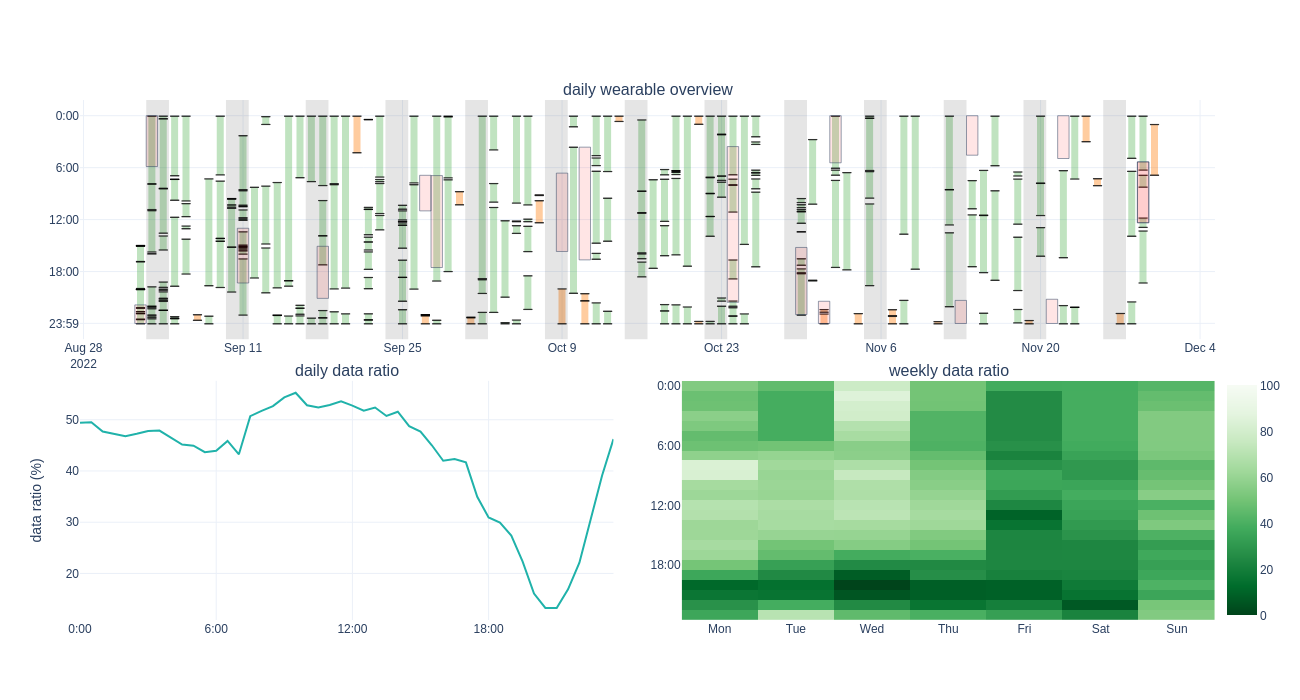

In [4]:
# sampe figure as above, but with the headache events as red rectangles
to_same_date = lambda time: datetime.combine(dt.date(), time)

fig = make_subplots(
    rows=2,
    cols=2,
    specs=[[{"colspan": 2}, {}], [{}, {}]],
    subplot_titles=[
        "daily wearable overview",
        "",
        "daily data ratio",
        "weekly data ratio",
    ],
    vertical_spacing=0.08,
    horizontal_spacing=0.06,
)
fig.update_layout(template="plotly_white", height=700)

# ---------------------------- Plotting ---------------------------- #
# --------------- row 1: wearable session data
# Add the wearable sessions (vertical interval bars for each day)
for _, session in list(df_wrist_wearable_sessions.iterrows()):
    hours, remainder = divmod(session.daily_wear_time.total_seconds(), 3600)
    minutes, seconds = divmod(remainder, 60)

    name = "too short " if session.daily_wear_time < pd.Timedelta(hours=6) else ""
    name += f"wearable sessions - {user}"

    fig.add_trace(
        go.Scattergl(
            x=[session.date] * 2,
            y=[
                to_same_date(session.start.time()),
                to_same_date(session.end.time()),
            ],
            line=dict(
                color=(
                    "rgba(44, 160, 44, 0.3)"  # cooked asparagus green
                    if session.daily_wear_time > pd.Timedelta(hours=6)
                    else "rgba(255, 127, 14, 0.4)"  # safety orange
                ),
                width=7,
            ),
            mode="markers+lines",
            marker=dict(
                line_color="black",
                line_width=1,
                color="black",
                symbol="line-ew",
                size=6,
                opacity=0.8,
            ),
            name=name,
            showlegend=False,
            hovertext=f"total daily wear time = {int(hours)}u{int(minutes)}",
        ),
        row=1,
        col=1,
    )


# Shade the weekends (gray shade)
dr = pd.date_range(
    df_tmp.index.date.min(), df_tmp.index.date.max() + pd.Timedelta(days=1), freq="D"
)
for sat in np.unique(dr[dr.dayofweek == 5]):
    fig.add_vrect(
        x0=pd.Timestamp(sat) - pd.Timedelta(hours=12),
        x1=pd.Timestamp(sat) + pd.Timedelta(hours=36),
        fillcolor="rgba(0, 0, 0, .1)",
        line_width=0,
    )

# Shade the headaches (red shade)
df_headache = EventDumpParser.parse_headache_events(df_eventdump)
if "deprecated" in df_headache.columns:
    df_headache = df_headache[df_headache["deprecated"] != True]
df_medicine = EventDumpParser.parse_medicine_events(df_eventdump)
df_headache["date"] = pd.to_datetime(df_headache["date"])
for _, r in df_headache.iterrows():
    # NOTE: this for loop ensures that the red shade is drawn correctly for multi-day
    #       headaches
    for d in pd.date_range(
        r.time.replace(hour=0, minute=0, second=0, microsecond=0), r.endTime, freq="1D"
    ):
        if r.time.date() == d.date():
            start = r.time
        else:
            start = d.replace(hour=0, minute=0, second=0, microsecond=0)
        if r.endTime.date() == d.date():
            end = r.endTime
        else:
            end = d.replace(hour=23, minute=59, second=59, microsecond=0)

        fig.add_shape(
            type="rect",
            x0=d - pd.Timedelta(hours=12),
            x1=d + pd.Timedelta(hours=12),
            y0=to_same_date(start.time()),
            y1=to_same_date(end.time()),
            line=dict(width=0.5),
            fillcolor="rgba(255, 0, 0, 0.1)",
        ),


# --------------- row 2 - col 1 - data ratio over time of day
fig.add_trace(
    go.Scatter(
        x=df_time_day_mean.index,
        y=df_time_day_mean["TMP"] * 100,
        name="1min data rate",
        showlegend=False,
        line=dict(color="lightseagreen"),
    ),
    row=2,
    col=1,
)
fig.update_yaxes(title_text="data ratio (%)", row=2, col=1)
dt_0 = df_time_day_mean.index[0]
fig.update_xaxes(
    type="date",
    tickformat="%H:%M",
    tickmode="array",
    ticktext=["0:00", "6:00", "12:00", "18:00", "23:59"],
    tickvals=[
        dt_0.replace(hour=0),
        dt_0.replace(hour=6),
        dt_0.replace(hour=12),
        dt_0.replace(hour=18),
        dt_0.replace(hour=23, minute=59),
    ],
    row=2,
    col=1,
)


# --------------- row 2 - col 2 - data ratio over time of week (heatmaps)
fig.add_trace(
    go.Heatmap(
        z=df_time_week_mean["TMP"] * 100,
        y=df_time_week_mean.index,
        x=df_time_week_mean["dow"],
        zmin=0,
        zmax=100,
        colorscale="greens_r",
        colorbar_len=0.48,
        colorbar_y=0.23,
        colorbar_x=1.002,
    ),
    row=2,
    col=2,
)


# --------------- axis settings
for row, col in [(1, 1), (2, 2)]:
    fig.update_yaxes(
        tickformat="%H:%M",
        tickmode="array",
        ticktext=["0:00", "6:00", "12:00", "18:00", "23:59"],
        tickvals=[
            dt.replace(hour=0),
            dt.replace(hour=6),
            dt.replace(hour=12),
            dt.replace(hour=18),
            dt.replace(hour=23, minute=59),
        ],
        autorange="reversed",
        row=row,
        col=col,
    )

fig.update_xaxes(
    tickmode="array",
    tickvals=[0, 1, 2, 3, 4, 5, 6],
    ticktext=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    row=2,
    col=2,
)
# hide the gridlines
fig.update_xaxes(zeroline=False, showgrid=False, row=2, col=2)
fig.update_yaxes(zeroline=False, showgrid=False, row=2, col=2)

# display the figure
if USE_PNG:
    fig.show(renderer="png", width=1300, height=700)
else:
    fig.show()

In [5]:
fig.write_html('../../figures/wearable_wear_behavior_MBRAIN.html')

> *Note*: The upper subplot illustrates the available wearable sessions, using similar bar intervals, providing an overview of wearable usage. In this subplot, weekends are marked in gray and headache intervals in red.
> The lower left subplot depicts the average data ratio for the time of day throughout the study period. This subgraph reveals a notable decline in wearable use between 17h30 and 22h30. Conversely, the lower right subplot utilizes a heatmap to display the average data ratio against the time of day, distributed over each day of the week, highlighting discernible patterns in wear frequency. 
> This heatmap elucidates that this specific participant has a tendency for reduced wearable use on Fridays and Saturdays, while Wednesdays exhibit the most wearable use. Remark how the reduced wearable usage during the evening period, shown by the through in the lower left subplot, is also discernable in this heatmap visualization.

In [21]:
# the global ratio
print(
    "average wearable data ratio -",
    round(
        100
        * df_wrist_wearable_sessions.session_dur.sum()
        / (
            df_wrist_wearable_sessions.iloc[-1].end
            - df_wrist_wearable_sessions.iloc[0].start
        ),
        3,
    ),
)
## now compute the intersection for each headache event
td = pd.Timedelta(0)
for _, h_slc in df_headache.iterrows():
    start, end = h_slc["time"], h_slc["endTime"]
    # get data ratio during
    valid_slcs = df_wrist_wearable_sessions[
        (df_wrist_wearable_sessions.start < end)
        & (df_wrist_wearable_sessions.end > start)
    ]
    for slc in valid_slcs.itertuples():
        td += min(slc.end, end) - max(slc.start, start)

print(
    "average wearable ratio during headaches -",
    round(100 * td / (df_headache["endTime"] - df_headache["time"]).sum(), 2),
    "%",
)

average wearable data ratio - 82.875
average wearable ratio during headaches - 77.07 %
